## Script Engine Performance Test

Two JS engines were compared: Rhino and Nashorn. These tests were used: [google-v8](https://github.com/v8/v8/tree/master/benchmarks) 

Benchmark suites were runned repeatedly for code warmup (JIT compiller optimization). 

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java:<br>

`java version "1.8.0_171"
Java(TM) SE Runtime Environment (build 1.8.0_171-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)`

In [1]:
# notebook import
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import json
import math
import scipy.stats.mstats as mstats

In [2]:
# main parameters for data analysis

# folder with all the dataset files
results_folder = "../../data/common-hotspot"
# count of runs used in analysis of performance dynamic
run_count = 500
# count of last analysed runs for mean scoring analysis
measure_count = 100

Define each case name: 
 * "rhino-0" - Rhino with "optimization-level=0" 
 * "rhino-9" - Rhino with "optimization-level=9"
 * "nashorn" - Nashorn with default settings
 * "nashorn-opt" -  Nashorn with "optimistic-types=true"

In [3]:
engine_cases = ["rhino-0", "rhino-9", "nashorn", "nashorn-opt"]

In [4]:
def load_engine_data(engine):
    with open(results_folder + "/" + engine + ".json", 'r') as file:
        return json.load(file)

In [5]:
# load data from JSON-files
data = {case: load_engine_data(case) for case in engine_cases}

In [6]:
def prepare_cases_data_set(data):
    suit_cases_names_tuples = [
        (suit_name, case_obj["name"])
        for suit_name in data["nashorn"][0]["suits"]
        for case_obj in data["nashorn"][0]["suits"][suit_name]["case"]
    ]
    return {
        suit_name + "::" + case_name: {
            engine_case: [
                caseObj["meanTime"]
                for i in range(run_count)
                for caseObj in data[engine_case][i]["suits"][suit_name]["case"]
                if caseObj["name"] == case_name
            ]
            for engine_case in engine_cases
        }
        for suit_name, case_name in suit_cases_names_tuples
    }


def prepare_suits_score_data_set(data):
    suit_names = [key for key in data["nashorn"][0]["suits"]]
    return {
        suit_name: {
            engine_case: [
                float(data[engine_case][i]["suits"][suit_name]["score"])
                for i in range(run_count)
            ]
            for engine_case in engine_cases
        }
        for suit_name in suit_names
    }


def prepare_total_score_data_set(data):
    return {
        engine_case: [
            float(data[engine_case][i]["totalScore"]) 
            for i in range(run_count)
        ]
        for engine_case in engine_cases
    }

In [7]:
def prepare_data_sets(data):  
    return prepare_cases_data_set(data), \
           prepare_suits_score_data_set(data), \
           prepare_total_score_data_set(data)

In [8]:
# datasets preparing:
# - cases_data_set: dataset with latency measurement 
#                   for each benchmark case
# - suits_score_data_set: dataset with score measurement 
#                         for each benchmark suit (cases group)
# - total_score_data_set: dataset with score measurement 
#                         for each engine case 
#                        (see description for "engine_cases" variable)
cases_data_set, suits_score_data_set, total_score_data_set = \
    prepare_data_sets(data)

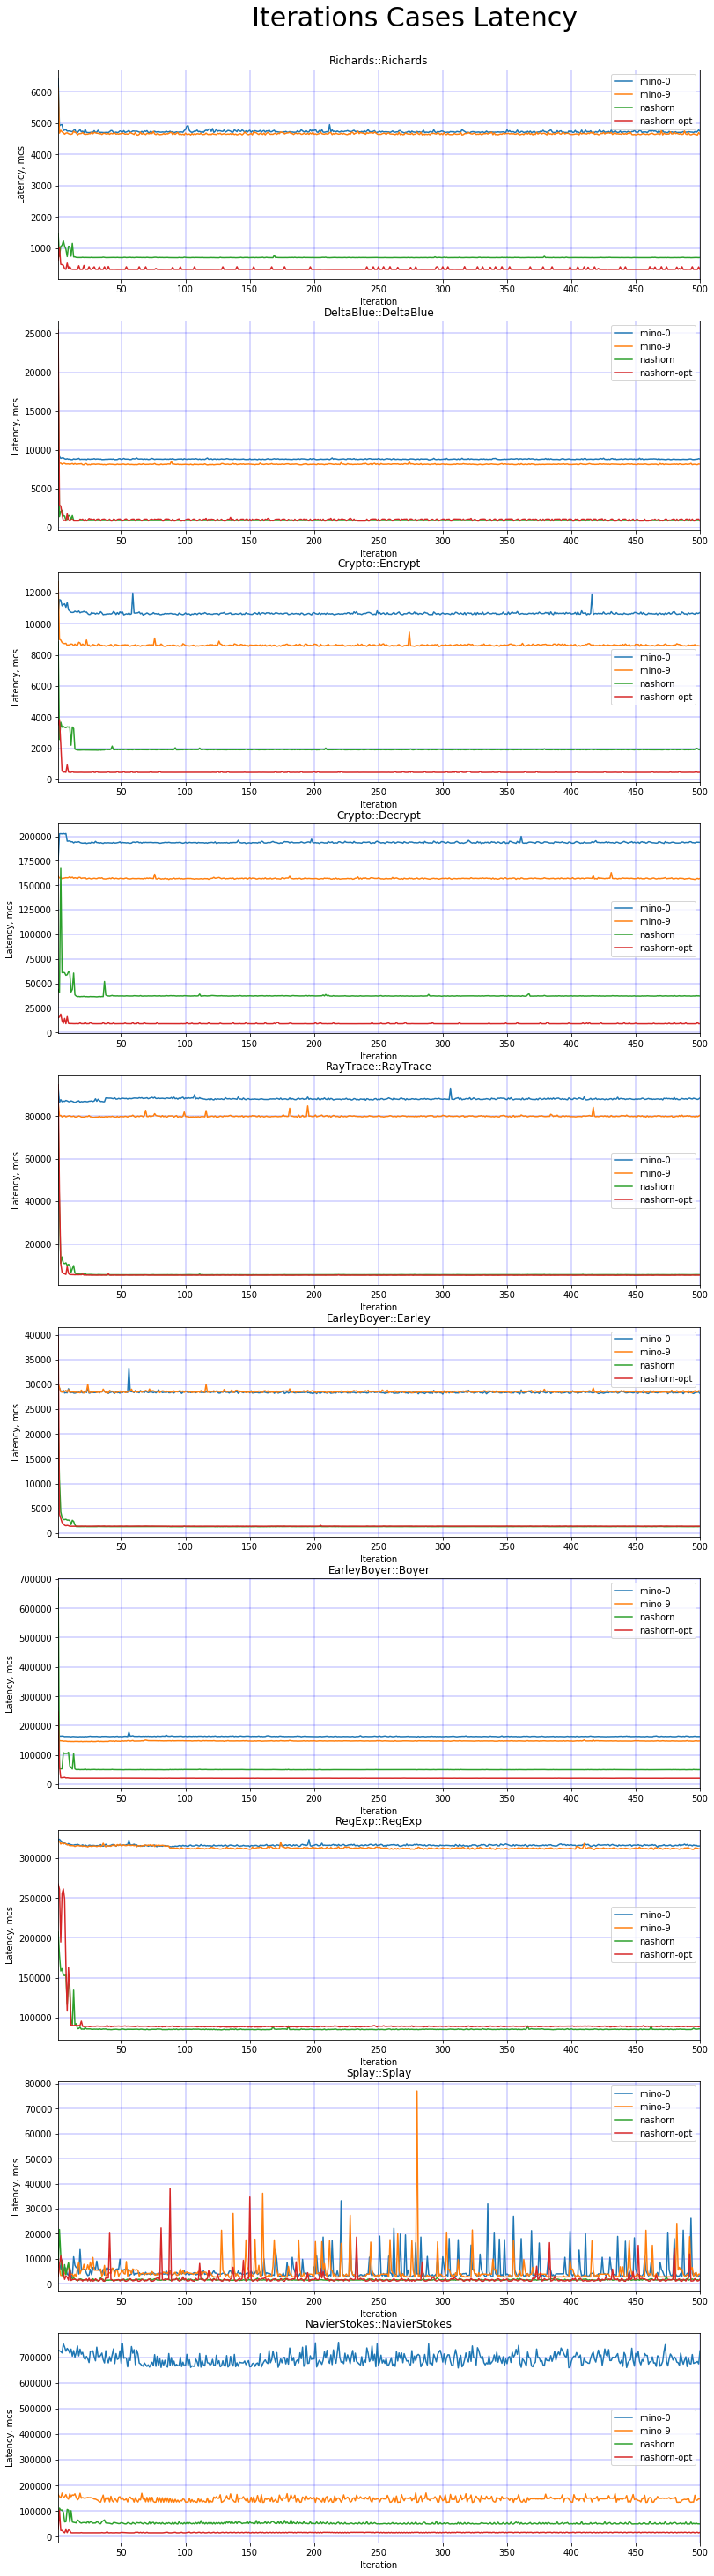

In [9]:
# plot for "cases_data_set" dynamic

nrows = len(cases_data_set)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 50))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Iterations Cases Latency', fontsize=30, y=0.9)
x = np.arange(1, run_count + 1)

for row, case_name \
    in zip(
        range(nrows),
        cases_data_set
    ):
    graph_data = cases_data_set[case_name]
    for engine_case in graph_data:
        axes[row].plot(x, graph_data[engine_case], label=engine_case)

    axes[row].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[row].set_title(case_name)
    axes[row].legend()
    axes[row].set_ylabel("Latency, mcs", size=10)
    axes[row].set_xlabel("Iteration", size=10)
    axes[row].set_xlim(xmin=1, xmax=run_count)
    axes[row].grid(color='b', linestyle='-', linewidth=0.3)
plt.show()

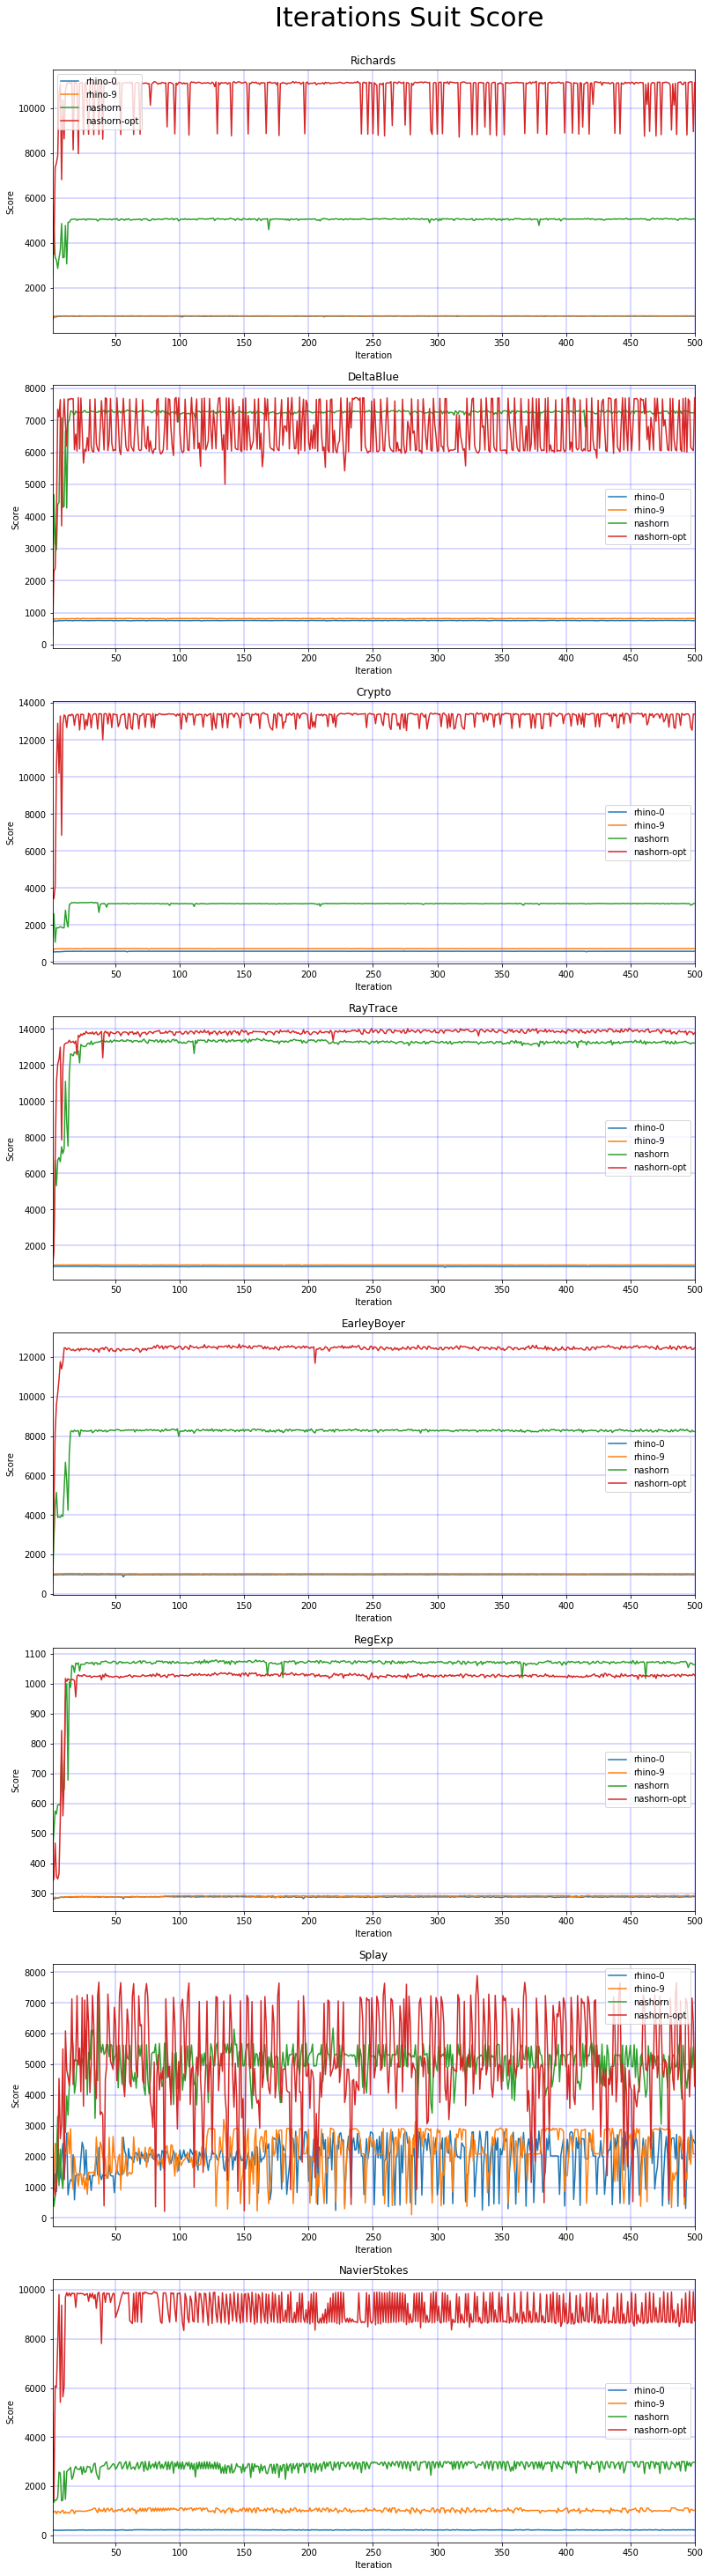

In [10]:
# plot for "suits_score_data_set" dynamic

nrows = len(suits_score_data_set)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 50))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Iterations Suit Score', fontsize=30, y=0.9)
x = np.arange(1, run_count + 1)

for row, suit_name \
    in zip(
        range(nrows),
        suits_score_data_set
    ):
    graph_data = suits_score_data_set[suit_name]
    for engine_case in graph_data:
        axes[row].plot(x, graph_data[engine_case], label=engine_case)

    axes[row].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[row].set_title(suit_name)
    axes[row].legend()
    axes[row].set_ylabel("Score", size=10)
    axes[row].set_xlabel("Iteration", size=10)
    axes[row].set_xlim(xmin=1, xmax=run_count)
    axes[row].grid(color='b', linestyle='-', linewidth=0.3)
plt.show()

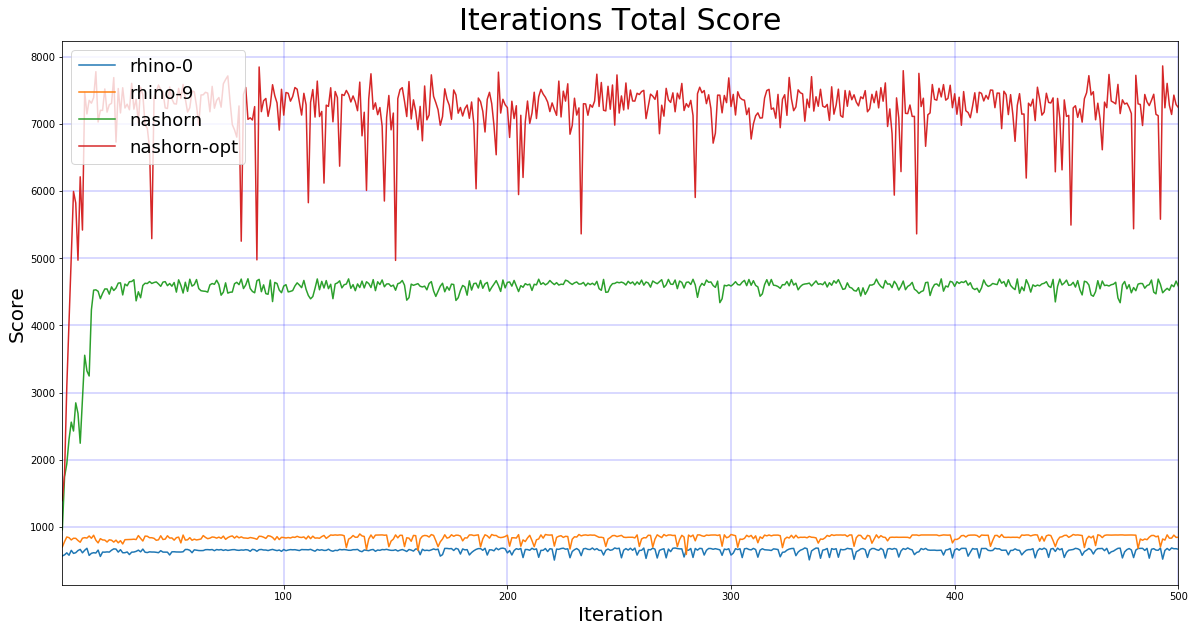

In [11]:
# plot for "total_score_data_set" dynamic

plt.figure(figsize=(20, 10))
x = np.arange(1, run_count + 1)

for engine_case in total_score_data_set.keys():
    plt.plot(x, total_score_data_set[engine_case], label=engine_case)
    
plt.ylabel("Score", size=20)
plt.xlabel("Iteration", size=20)
plt.grid(color='b', linestyle='-', linewidth=0.3)
plt.legend(prop={'size': 18})
plt.title('Iterations Total Score', fontsize=30, y=1.01)
plt.xlim(xmin=1, xmax=run_count)
plt.show()

In [12]:
def prepare_cases_means_set(cases_data_set):
    return {
        case_name: {
            engine_case:
                math.floor(
                    mstats.gmean(
                    cases_data_set[case_name] \
                        [engine_case][-measure_count:],
                    dtype=int
                    )
                )
            for engine_case in engine_cases
        }
        for case_name in cases_data_set
    }


def prepare_suits_score_relative_set(suits_score_data_set):
    suits_score_means = {
        suit_name: {
            engine_case:
                mstats.gmean(
                    suits_score_data_set[suit_name] \
                        [engine_case][-measure_count:],
                    dtype=float
                )
            for engine_case in engine_cases
        }
        for suit_name in suits_score_data_set
    }

    result = {}
    
    for suit_name in suits_score_means:
        min_suits_score = min(suits_score_means[suit_name].values())
        result[suit_name] = {
            engine_case: 
                suits_score_means[suit_name][engine_case] / min_suits_score
            for engine_case in engine_cases
        }

    return result


def prepare_total_score_relative_set(total_score_data_set):
    total_score_means = {
        engine_case: mstats.gmean(
            total_score_data_set[engine_case][-measure_count:],
            dtype=float
        )
        for engine_case in engine_cases}

    min_total_score = min(total_score_means.values())

    return {
        engine_case: total_score_means[engine_case] / min_total_score
        for engine_case in engine_cases
    }


In [13]:
# datasets preparing for total relative comparision:
# - cases_means_set: geometric mean 
#                    for last <measure_count> analyzed runs' latency 
#                    for each benchmark case and each engine case
cases_means_set = prepare_cases_means_set(cases_data_set)
# - suits_score_relative_set: geometric mean
#                    for last <measure_count> analyzed runs' score 
#                    for each benchmark suit and each engine case
suits_score_relative_set = \
    prepare_suits_score_relative_set(suits_score_data_set)
# - total_score_relative_set: geometric mean
#                    for last <measure_count> analyzed runs' total score 
#                    for each engine case
total_score_relative_set = \
    prepare_total_score_relative_set(total_score_data_set)

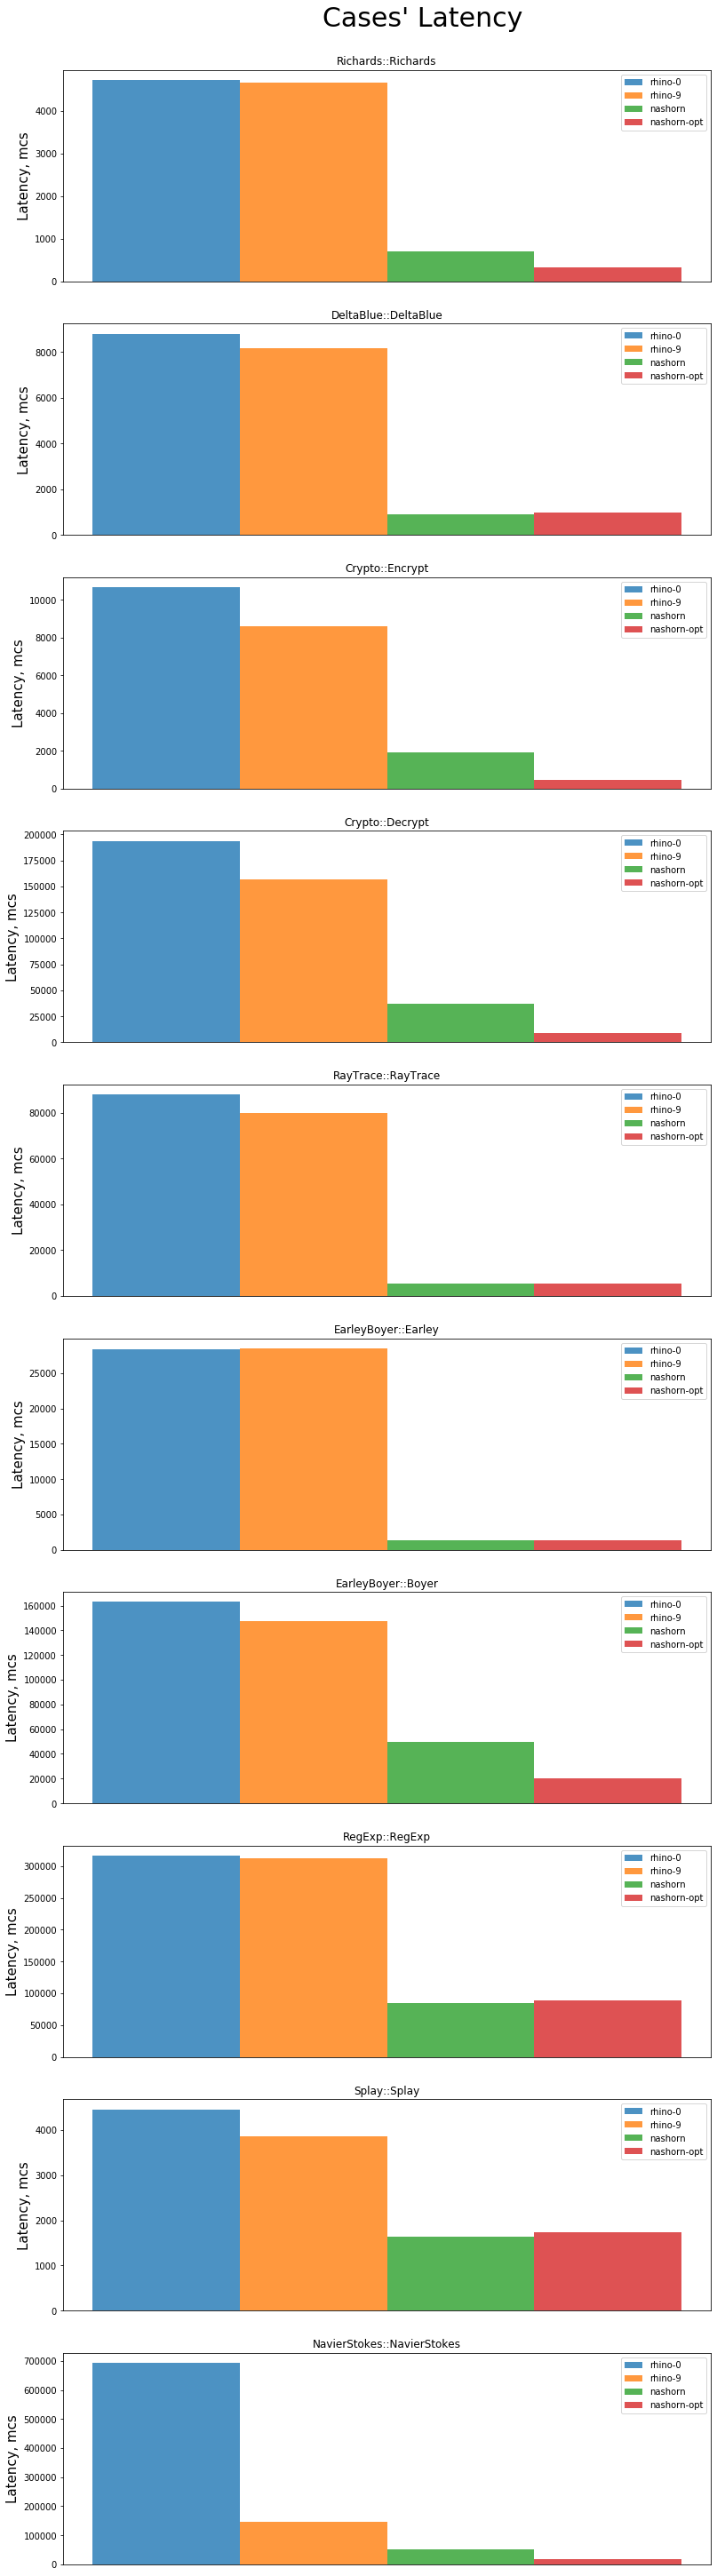

In [14]:
# vertical bars for relative engine cases' latency comparision 
# for each benchmark case

bar_width = 1
opacity = 0.8
nrows = len(cases_means_set)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 50))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Cases\' Latency', fontsize=30, y=0.9)

for row, case_name \
        in zip(
        range(nrows),
        cases_means_set
    ):
    graph_data = cases_means_set[case_name]
    n_groups = len(graph_data.keys())
    index = np.arange(n_groups)

    for i, engine_case in enumerate(graph_data):
        axes[row].bar(
            1 + bar_width * i,
            graph_data[engine_case],
            bar_width,
            alpha=opacity, label=engine_case
        )
    axes[row].set_title(case_name)
    axes[row].set_ylabel('Latency, mcs', size=15)
    axes[row].set_xticks([])
    axes[row].legend()
plt.show()

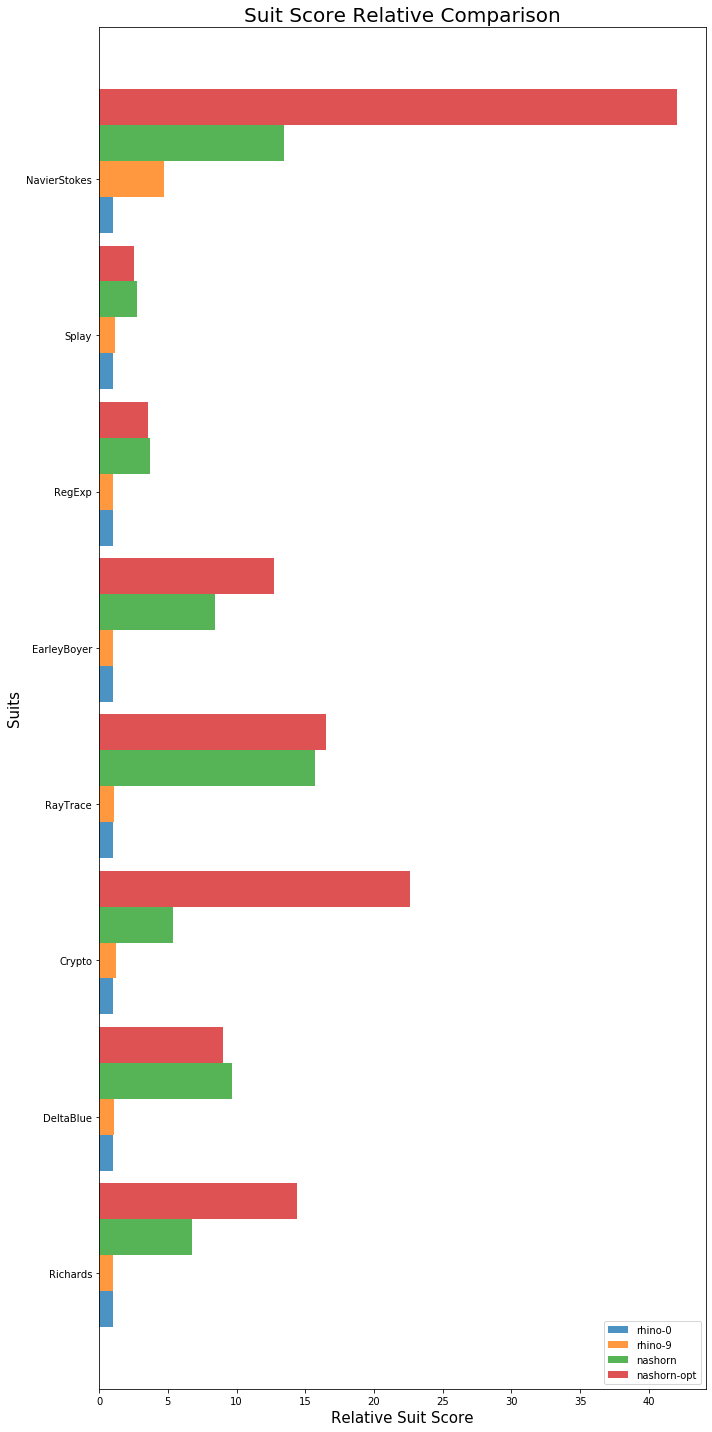

In [15]:
# horizontal bars for relative engine cases' score comparision 
# for each benchmark suit

n_groups = len(suits_score_relative_set.keys())

fig, ax = plt.subplots(figsize=(10, 20))
index = np.arange(n_groups)
bar_width = 0.23
opacity = 0.8
 
for i, engine_case in enumerate(total_score_relative_set):
    plt.barh(
        index + i * bar_width, 
        [
            suits_score_relative_set[suits][engine_case] 
            for suits in suits_score_relative_set
        ], 
        bar_width,
        alpha=opacity, label=engine_case
    )
 
plt.ylabel('Suits', size=15)
plt.xlabel('Relative Suit Score', size=15)
plt.title('Suit Score Relative Comparison', size=20)
plt.yticks(index + bar_width, suits_score_relative_set.keys())
plt.legend()
 
plt.tight_layout()
plt.show()

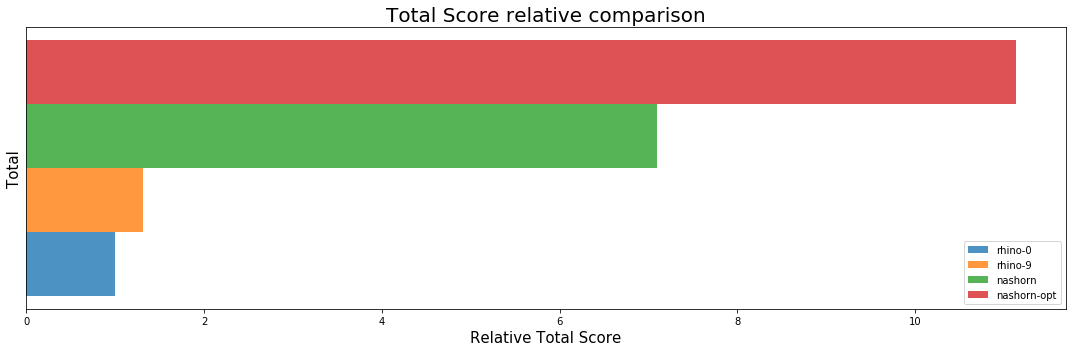

In [16]:
# horizontal bar for relative engine cases' total score comparision

plt.figure(figsize=(15, 5))
bar_width = 0.35
opacity = 0.8

for i, engine_case in enumerate(total_score_relative_set):
    plt.barh(
        1 + bar_width * i, 
        total_score_relative_set[engine_case], 
        bar_width, 
        alpha=opacity, label=engine_case
    )
 
plt.ylabel('Total', size=15)
plt.xlabel('Relative Total Score', size=15)
plt.title('Total Score relative comparison', size=20)
plt.yticks([0], ["Total Score"])
plt.legend()
 
plt.tight_layout()
plt.show()